<a href="https://colab.research.google.com/github/MarshaGomez/DNN-Sketches-image-analysis/blob/main/Code/sketches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setting up the project


In [ ]:
import numpy as np
from numpy.linalg import norm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
zip_path = '/content/gdrive/Shareddrives/COMPUTER_VISION/MIM_zipped.zip'
!cp "{zip_path}" .
!unzip -q MIM_zipped.zip
!rm MIM_zipped.zip


### LSH Class


In [ ]:
# def singleton(class_):
#     instances = {}
#     def getinstance(*args, **kwargs):
#         if class_ not in instances:
#             instances[class_] = class_(*args, **kwargs)
#         return instances[class_]
#     return getinstance

# @singleton
# per adesso è più scomodo che utile averlo come singleton
class LSH:
  def __init__(self, mus, sigmas, g = 10, h = 20, w = 4):
    """
    We have to find a way to load the stored index if exists or initialize the 
    initial structure
    @param
    mus = array di medie
    sigmas = array di standard deviation
    """
    self._index = {}
    assert mus.shape == sigmas.shape, "mus and sigmas must be of the same shape"
    self.x = np.random.normal(mus, sigmas, size=(g, h, sigmas.shape[0]))
    self.w = np.ones((g, h, 1)) * w
    self.b = np.random.rand(g, h, 1) * w

  def _hash(self, features):
    """
    crea l'hash di più cose contemporaeamente si aspetta un array composto dalle features una sotta l'altra (linguaggio super matematico)
    """
    # g = np.trunc((np.dot(p, self.x) + self.b) / self.w)
    #g = np.trunc((np.dot(self.x, p) + self.b) / self.w) questo funziona con 1
    # g = np.transpose(np.trunc(((np.dot(self.x, p.T) + self.b) / self.w)), (0,2,1)) miglior modo di vederlo
    return np.transpose(np.trunc(((np.dot(self.x, features.T) + self.b) / self.w)), (0,2,1)).astype(int).astype(str)

  def insert(self, features, ids, labels):
    """
    Insert new data, ci aspettiamo un array d
    """
    g = self._hash(features)
    assert features.shape[0] == len(ids), "mismatch between ids length and features"
    i = 0
    for g_function in g:
      for row in g_function:
        bucket_id = ','.join(row)
        if not bucket_id in self._index:
          self._index[bucket_id] = { 'features': np.array([features[i % features.shape[0]]]), 'ids': np.array([ids[i % features.shape[0]]]), 'labels': np.array([labels[i % features.shape[0]]])}
        else:
          if (self._index[bucket_id]['ids'] == ids[i % features.shape[0]]).any():
            print("duplicate")
            continue
          print("collision inserted")
          self._index[bucket_id]['features'] = np.vstack((self._index[bucket_id]['features'], features[i % features.shape[0]]))
          self._index[bucket_id]['ids'] = np.vstack((self._index[bucket_id]['ids'], ids[i % features.shape[0]]))
          self._index[bucket_id]['labels'] = np.vstack((self._index[bucket_id]['labels'], labels[i % features.shape[0]]))
        i += 1
  
  def query(self, features, top_k, mode = 'euclidean'):
    """
    Query the data
    """
    g = self._hash(np.array([features]))
    i = 0
    k = None
    assert mode in ['similarity', 'euclidean'], "mode must be similarity or euclidean"
    for g_function in g:
      for row in g_function:
        bucket_id = ','.join(row)
        if bucket_id in self._index:
          # posso avere duplicati perchè se i punti vengono inseriti in più bucket, posso avere duplicati
          # quindi devo eliminarli
          # l'ho messo qua fuori che il controllo duplicati è uguale per tutte e due le distanze
          print(f'bucket {bucket_id}')
          if k is not None:
            print("duplicate")
            duplicate_index = np.isin(self._index[bucket_id]['ids'], k['ids'])
            if duplicate_index.all():
              continue; # se sono tutti duplicati non ha senso contare nulla
            bucket = {}
            bucket['ids'] = self._index[bucket_id]['ids'][~duplicate_index] # prendo quelli che non sono duplicati
            print(duplicate_index)
            print(self._index[bucket_id]['features'])
            bucket['features'] = self._index[bucket_id]['features'][~duplicate_index.flatten()] # each duplicate index must delete a row of features
            bucket['labels'] = self._index[bucket_id]['labels'][~duplicate_index]
          else:
            bucket = self._index[bucket_id]
        
          if mode == 'euclidean':
            print(bucket['features'].shape)
            dist = norm(bucket['features'] - np.array(features), axis=1)
            if k is None:
              idx_partitioned = np.argpartition(dist, top_k - 1 if dist.shape[0] - 1 > top_k - 1 else dist.shape[0] - 1)
              k = {}
              # qua è più comodo avere array 1- dimensionali
              k['ids'] = bucket['ids'][idx_partitioned].flatten()
              k['labels'] = bucket['labels'][idx_partitioned].flatten()
              k['distances'] = dist[idx_partitioned]
              continue
            # https://stackoverflow.com/questions/10337533/a-fast-way-to-find-the-largest-n-elements-in-an-numpy-array
            # argpartition sembra essere incredibilmente veloce
            # ma non ordina completamente, ordina solo rispetto un punto, nel senso
            # io gli sto dicendo butta quelli più piccoli di k da una parte e quelli più grandi all'altra, ma non sto ordinando
            if k['distances'].shape[0] < top_k:
                print((k['distances'].shape, dist.shape))
                distances = np.concatenate((k['distances'], dist))
                print((k['ids'].shape, bucket['ids'].shape))
                print(k['ids'])
                print(bucket['ids'])
                ids = np.concatenate((k['ids'], bucket['ids']))
                print((k['labels'].shape, bucket['labels'].shape))
                labels = np.concatenate((k['labels'], bucket['labels']))
                idx_sorted = np.argpartition(distances, top_k - 1 if distances.shape[0] - 1 > top_k else distances.shape[0] - 1)
                k['ids'] = ids[idx_sorted]
                k['labels'] = labels[idx_sorted]
                k['distances'] = distances[idx_sorted]
                print(f'k = {k}')
                continue

            idx = dist < np.max(k['distances'])
            print(f"idx = {idx}")
            if np.any(idx):
              distances = np.concatenate((k['distances'], dist[idx]))
              ids = np.concatenate((k['ids'], bucket['ids'][idx]))
              labels = np.concatenate((k['labels'], bucket['labels'][idx]))
              idx_sorted = np.argpartition(distances, top_k - 1 if distances.shape[0] - 1 > top_k else distances.shape[0] - 1)
              idx_sorted = idx_sorted[:top_k - 1 if distances.shape[0] - 1 > top_k else distances.shape[0] - 1]
              k['ids'] = ids[idx_sorted]
              k['labels'] = labels[idx_sorted]
              k['distances'] = distances[idx_sorted]

          else:
            print(bucket['features'].shape)
            sim = np.sum(bucket['features'] * np.array(features), axis=1) / (norm(bucket['features'], axis=1) * norm(np.array([features]), axis=1))
            if k is None:
              idx_partitioned = np.argpartition(sim, top_k - 1 if sim.shape[0] - 1 > top_k - 1 else sim.shape[0] - 1)[::-1]
              k = {}
              # qua è più comodo avere array 1- dimensionali
              k['ids'] = bucket['ids'][idx_partitioned].flatten()
              k['labels'] = bucket['labels'][idx_partitioned].flatten()
              k['similarities'] = sim[idx_partitioned]
              continue
            # https://stackoverflow.com/questions/10337533/a-fast-way-to-find-the-largest-n-elements-in-an-numpy-array
            # argpartition sembra essere incredibilmente veloce
            # ma non ordina completamente, ordina solo rispetto un punto, nel senso
            # io gli sto dicendo butta quelli più piccoli di k da una parte e quelli più grandi all'altra, ma non sto ordinando
            if k['similarities'].shape[0] < top_k:
                print((k['similarities'].shape, sim.shape))
                similarities = np.concatenate((k['similarities'], sim))
                print((k['ids'].shape, bucket['ids'].shape))
                print(k['ids'])
                print(bucket['ids'])
                ids = np.concatenate((k['ids'], bucket['ids']))
                print((k['labels'].shape, bucket['labels'].shape))
                labels = np.concatenate((k['labels'], bucket['labels']))
                idx_sorted = np.argpartition(similarities, top_k - 1 if similarities.shape[0] - 1 > top_k else similarities.shape[0] - 1)[::-1]
                k['ids'] = ids[idx_sorted]
                k['labels'] = labels[idx_sorted]
                k['similarities'] = similarities[idx_sorted]
                print(f'k = {k}')
                continue

            idx = sim > np.min(k['similarities'])
            print(f"idx = {idx}")
            if np.any(idx):
              similarities = np.concatenate((k['similarities'], sim[idx]))
              ids = np.concatenate((k['ids'], bucket['ids'][idx]))
              labels = np.concatenate((k['labels'], bucket['labels'][idx]))
              idx_sorted = np.argpartition(similarities, top_k - 1 if similarities.shape[0] - 1 > top_k else similarities.shape[0] - 1)[::-1]
              idx_sorted = idx_sorted[:top_k - 1 if similarities.shape[0] - 1 > top_k else similarities.shape[0] - 1]
              k['ids'] = ids[idx_sorted]
              k['labels'] = labels[idx_sorted]
              k['similarities'] = similarities[idx_sorted]
        i += 1
    # ora ordino totalmente i risultati
    if mode == 'euclidean':
      idx_sorted = np.argsort(k['distances'])
      idx_sorted = idx_sorted[:top_k - 1 if k['distances'].shape[0] - 1 > top_k else k['distances'].shape[0] - 1]
      k['distances'] = k['distances'][idx_sorted]
      k['ids'] = k['ids'][idx_sorted]
      k['labels'] = k['labels'][idx_sorted]
      return k
    idx_sorted = np.argsort(k['similarities'])[::-1]
    idx_sorted = idx_sorted[:top_k - 1 if k['similarities'].shape[0] - 1 > top_k else k['similarities'].shape[0] - 1]
    k['similarities'] = k['similarities'][idx_sorted]
    k['ids'] = k['ids'][idx_sorted]
    k['labels'] = k['labels'][idx_sorted]
    return k

  def store(self):
    pass

  def reindex(self):
    pass

In [ ]:
# IMPORTANT: THE ABOVE CLASS IS A SINGLETON, SO IF YOU INITIALIZE WITH SOME INFO
# YOU WILL HAVE BACK THAT INFO, OTHER INITILIAZATION WILL GIVE YOU THE FIRST OBJECT INSTANTIATED

#### TESTING PURPOSE
# mus = np.array([1, 100])
# sigmas = np.array([0.1, 10])
# index = LSH(mus, sigmas, g= 2, h=2)
# print('x=')
# print(index.x)
# print('w=')
# print(index.w)
# print('b=')
# print(index.b)
# print('ps =')
# print(np.array([[1,1], [2, 2], [3, 3], [1, 1]]))
# print('insert')
# print(index.insert(
#      np.array([[1,1], [2, 2], [3, 3], [1, 1]]), 
#      np.array(['uno', 'due', 'tre','quattro']),
#      np.array([0,0,1,1])
#      )
# )
# print(index._index)
# print('query')
# print(index.query([1,1], 4))
# print(index)

### Loading images DATA


In [ ]:
import os 
from IPython.display import display
from ipywidgets import Image

#data loading
# reading from unzipped
BASE_DIR = "/content/content/gdrive/Shareddrives/COMPUTER_VISION/MIRCV"
# FILELIST_PATH = BASE_DIR + "/filelist.txt"
SKETCHES_DIR = BASE_DIR + "/sketches/png"
MIRFLICKR_DIR = BASE_DIR + "/mirflickr/mirflickr25k"

#print(FILELIST_PATH)

#num_folders = os.listdir(SKETCHES_DIR)
#print(num_folders)

In [ ]:
# sketch image displaying 
filename = "airplane/1.png"
image1 = os.path.join(SKETCHES_DIR, filename)
display(Image.from_file(image1, width=300, height=400))

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04W\x00\x00\x04W\x08\x00\x00\x00\x00\x105\xd1!\x00\…

In [ ]:
# mirflickr image displaying 
filename = "png/im20.jpg"
image1 = os.path.join(MIRFLICKR_DIR, filename)
display(Image.from_file(image1, width=300, height=400))

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xe2\x0cXICC_PROFILE\x00\x01\x…

In [ ]:
INPUT_SHAPE = (150, 150, 1)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 64

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
#yields batches of images from the subdirectories 
#found in the sketches directory [class_0 ... class_250]
#together with class labels.

#images normalization 
sketches_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
mirflickr_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

sketches_generator = sketches_datagen.flow_from_directory(
        # This is the target directory
        SKETCHES_DIR,
        shuffle=False,
        # All images will be resized to 150x150
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE)

mirflickr_generator = mirflickr_datagen.flow_from_directory(
        # This is the target directory
        MIRFLICKR_DIR,
        shuffle=False,
        # All images will be resized to 150x150
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE)

"""
sketches_generator = image_dataset_from_directory(
    directory=SKETCHES_DIR,
    labels="inferred",
    shuffle=False,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)
"""

Found 20000 images belonging to 250 classes.
Found 25000 images belonging to 1 classes.


'\nsketches_generator = image_dataset_from_directory(\n    directory=SKETCHES_DIR,\n    labels="inferred",\n    shuffle=False,\n    image_size=(IMG_HEIGHT, IMG_WIDTH),\n    batch_size=BATCH_SIZE\n)\n'

In [ ]:
# generate first (images, labels) batch
for images_batch, labels_batch in sketches_generator:
  first_i_batch = images_batch
  first_l_batch = labels_batch
  break

for images_batch, labels_batch in mirflickr_generator:
  first_mri_batch = images_batch
  first_mrl_batch = labels_batch
  break

print(first_i_batch.shape)
print(first_l_batch.shape)
print()
#print(first_i_batch[0])
print(first_mri_batch.shape)
print(first_mrl_batch.shape)
#print(first_mri_batch[0])

(64, 150, 150, 3)
(64, 250)

(64, 150, 150, 3)
(64, 1)


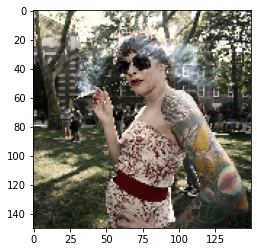

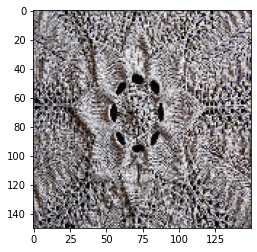

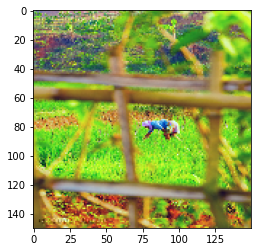

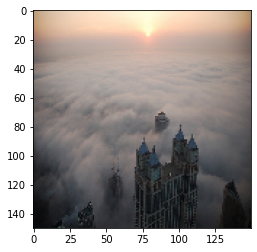

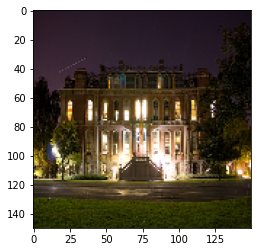

In [ ]:
# show first 5 sketches
import matplotlib.pyplot as plt

for i in range(5):
  plt.figure(i)
  #plt.title(str(first_l_batch[i]))
  imgplot = plt.imshow(image.array_to_img(first_mri_batch[i]))
  i += 1

plt.show()

### Loading DNN for features extraction

In [ ]:
#loading Inception DNN
from tensorflow.keras.applications.inception_v3 import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3),
                  pooling='avg')

# conv_base.summary()

In [ ]:
#Extracting features using the pretrained convolutional base 

def extract_features(extractor, generator, sample_count):
  features = None #extractor output shape 
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = extractor.predict(inputs_batch)
    if features is None:
      features = features_batch
    else:
      features = np.vstack((features, features_batch))
    i += 1
    if i * BATCH_SIZE >= sample_count:
      break
  
  return features

sketches_features = extract_features(conv_base, sketches_generator, 1000)
mirflickr_features = extract_features(conv_base, mirflickr_generator, 1000)

In [ ]:
print(sketches_features.shape)
print(mirflickr_features.shape)
print(sketches_features[0])
print()
print(mirflickr_features[0])
print(sketches_features.nbytes)
print(mirflickr_features.nbytes)

(1024, 2048)
(1024, 2048)
[0.06740259 0.         0.10691507 ... 0.68938357 0.00447192 0.        ]

[0.7337071  0.1837798  0.84581476 ... 0.5997329  0.09964679 0.8443416 ]
8388608
8388608


In [ ]:
all_features = np.vstack((sketches_features, mirflickr_features))
print(np.mean(all_features, axis=0))
print(np.std(all_features, axis=0))
lsh_base = LSH(np.mean(all_features, axis=0), np.std(all_features, axis=0), g=5, h=1)


[0.6360182  0.41078553 0.68125015 ... 0.81911397 0.66495466 0.63561535]
[0.7728869  0.67477167 0.83479923 ... 0.9750316  0.89763904 0.9776087 ]


In [ ]:
lsh_base.insert(sketches_features, sketches_generator.filenames[:sketches_features.shape[0]], sketches_generator.labels[:sketches_features.shape[0]])

duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate


In [ ]:
lsh_base.insert(mirflickr_features, mirflickr_generator.filenames[:mirflickr_features.shape[0]], np.array([250] * mirflickr_features.shape[0])) # il distractor diventa la classe 250 (l'altro va da 0 a 249)

duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate


In [ ]:
query_result_ed = lsh_base.query(sketches_features[0], 50)
query_result_sim = lsh_base.query(sketches_features[0], 50, mode='similarity')

bucket 31
(27, 2048)
bucket 23
duplicate
[[False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]
[[0.06153866 0.02776673 0.15248746 ... 0.62265086 0.27298966 0.        ]
 [0.08299042 0.09295793 0.12934345 ... 1.1234916  0.         0.        ]
 [0.06740259 0.         0.10691507 ... 0.68938357 0.00447192 0.        ]
 ...
 [0.         0.13269155 0.13160211 ... 0.10080072 0.         0.        ]
 [2.3330774  0.36688533 0.53914195 ... 1.9900708  0.43517622 0.        ]
 [0.05872383 0.         0.5526689  ... 0.13886863 0.0827848  0.17074347]]
(13, 2048)
((27,), (13,))
((27,), (13,))
['airplane/1.png' 'angel/202.png' 'apple/340.png' 'arm/453.png'
 'armchair/537.png' 'armchair/556.png' 'banana/806.png' 'apple/339.png'
 'apple/351.png' 'apple/389.png' 'arm/411.png' 'armchair/494.png'
 'backpack/784.png' 'barn/893.png' 'barn/896.png' 'angel/211.png'
 'apple/345.png' 'alarm clock/132.png' 'angel/197.png' 'arm/431.png'
 

In [ ]:
print(query_result_ed)
print(query_result_sim)

{'ids': array(['airplane/1.png', 'apple/355.png', 'apple/393.png',
       'apple/389.png', 'banana/806.png', 'arm/411.png', 'angel/209.png',
       'armchair/556.png', 'airplane/13.png', 'arm/408.png',
       'apple/397.png', 'barn/933.png', 'arm/413.png', 'arm/475.png',
       'apple/340.png', 'apple/395.png', 'armchair/537.png',
       'baseball bat/1007.png', 'apple/391.png', 'angel/216.png',
       'angel/180.png', 'airplane/15.png', 'apple/347.png',
       'alarm clock/110.png', 'angel/192.png', 'ashtray/587.png',
       'airplane/18.png', 'apple/345.png', 'angel/197.png',
       'angel/202.png', 'angel/178.png', 'baseball bat/1037.png',
       'png/im10769.jpg', 'airplane/12.png', 'arm/414.png',
       'airplane/56.png', 'apple/388.png', 'barn/896.png',
       'backpack/798.png', 'png/im10400.jpg', 'alarm clock/115.png',
       'apple/339.png', 'arm/453.png', 'png/im10552.jpg', 'angel/211.png',
       'arm/431.png', 'banana/836.png', 'backpack/784.png',
       'barn/895.png'], dt

### Fine tuning with classification

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# ho trattato il fine tuning e sopra come due pezzi di codice differenti, così posso eseguire solo 
# uno o l'altro 
# va comunque eseguito l'indice sopra e la parte che inizializza le variabili globali
# come la batch size e la path di sketches dir

INPUT_SHAPE = (150, 150, 1)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 512
MODEL_PATH = '/content/drive/Shareddrives/COMPUTER_VISION/models'

def extract_features(extractor, generator, sample_count):
  features = None #extractor output shape 
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = extractor.predict(inputs_batch)
    if features is None:
      features = features_batch
    else:
      features = np.vstack((features, features_batch))
    i += 1
    if i * BATCH_SIZE >= sample_count:
      break
  
  return features


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    SKETCHES_DIR,
    shuffle=True,
    # All images will be resized to 150x150
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    SKETCHES_DIR,
    shuffle=True,
    # All images will be resized to 150x150
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='validation') 

resnet_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3),
                  pooling='avg')

for layer in resnet_base.layers:
  layer.trainable = True


model_classification = keras.models.Sequential()
model_classification.add(resnet_base)
model_classification.add(layers.Dense(250, activation='sigmoid'))
model_classification.compile(loss='binary_crossentropy',
              # optimizer=keras.optimizers.RMSprop(lr=2e-5),
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
model_classification.summary()


model_checkpoint = ModelCheckpoint('checkpoint.h5', save_best_only=True, save_weights_only=True, verbose=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=25)

print(len(train_generator), BATCH_SIZE)

history = model_classification.fit(
  train_generator,
  steps_per_epoch = 20000 * 0.8 // BATCH_SIZE,
  epochs=10,
  validation_data = validation_generator,
  validation_steps =  20000 * 0.2 // BATCH_SIZE,
  callbacks = [callback, model_checkpoint]
  )
model_classification.load_weights('checkpoint.h5')
models.save_model(model_classification, os.path.join(MODEL_PATH, 'resnet_v2_finetuning_classification.h5'))

Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 250)               512250    
Total params: 22,315,034
Trainable params: 22,280,602
Non-trainable params: 34,432
_________________________________________________________________
32 512
Epoch 1/10
31/31 [==============================] - 108s 3s/step - loss: 0.2142 - acc: 0.0226 - val_loss: 0.0511 - val_acc: 0.0047

Epoch 00001: val_loss improved from inf to 0.05110, saving model to checkpoint.h5
Epoch 2/10
31/31 [==============================] - 80s 3s/step - loss: 0.0211 - acc: 0.1920 - val_loss: 0.0250 - val_acc: 0.0653

Epoch 00002: val_loss improved from 0.05110 to 0.02503, savi

NameError: ignored

In [ ]:
sketches_features_finetuned = extract_features(resnet_base, sketches_generator, 1000)
mirflickr_features_finetuned = extract_features(resnet_base, mirflickr_generator, 1000)
all_features = np.vstack((sketches_features_finetuned, mirflickr_features_finetuned))
print(np.mean(all_features, axis=0))
print(np.std(all_features, axis=0))
lsh_finetuned = LSH(np.mean(all_features, axis=0), np.std(all_features, axis=0), g=20, h=1)
lsh_finetuned.insert(sketches_features_finetuned, sketches_generator.filenames[:sketches_features_finetuned.shape[0]], sketches_generator.labels[:sketches_features_finetuned.shape[0]])
lsh_finetuned.insert(mirflickr_features_finetuned, mirflickr_generator.filenames[:mirflickr_features_finetuned.shape[0]], np.array([250] * mirflickr_features_finetuned.shape[0])) # il distractor diventa la classe 250 (l'altro va da 0 a 249)
query_result_ed = lsh_finetuned.query(sketches_features_finetuned[0], 50)
query_result_sim = lsh_finetuned.query(sketches_features_finetuned[0], 50, mode='similarity')


Streaming output truncated to the last 5000 lines.
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate
duplicate

In [ ]:
print(query_result_ed)
print(query_result_sim)

{'ids': array(['airplane/1.png', 'airplane/49.png', 'airplane/32.png',
       'airplane/64.png', 'airplane/40.png', 'airplane/56.png',
       'airplane/48.png', 'airplane/26.png', 'airplane/63.png',
       'airplane/37.png', 'airplane/29.png', 'airplane/2.png',
       'airplane/59.png', 'airplane/25.png', 'airplane/58.png',
       'airplane/51.png', 'airplane/67.png', 'airplane/24.png',
       'airplane/16.png', 'airplane/52.png', 'airplane/62.png',
       'airplane/61.png', 'airplane/14.png', 'airplane/44.png',
       'airplane/36.png', 'airplane/39.png', 'airplane/19.png',
       'airplane/41.png', 'airplane/27.png', 'airplane/5.png',
       'airplane/47.png', 'airplane/46.png', 'airplane/6.png',
       'airplane/4.png', 'airplane/50.png', 'airplane/21.png',
       'airplane/57.png', 'airplane/42.png', 'airplane/20.png',
       'airplane/17.png', 'airplane/33.png', 'airplane/54.png',
       'airplane/12.png', 'airplane/43.png', 'airplane/10.png',
       'airplane/13.png', 'airplane/3